tgb - 5/18/2020 - Spectral enthalpy budget building on:  
1. [https://agupubs.onlinelibrary.wiley.com/doi/full/10.1029/2019GL084130] for its formulation  
2. [https://github.com/tbeucler/2019_WMI/blob/master/dev/tbeucler/004_Landau_Surface_Tension.ipynb] for some utilities to facilitate plotting    
3. [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/018_Water_budget_diagnostics.ipynb] to close the local enthalpy budget in SPCAM3. May not need it if investigating zonal structure of coarse-scale MSE as a first step.  

# Initialization

## Import python libraries

In [25]:
import xarray as xr
import numpy as np
import numpy.fft as fft
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy.integrate as sin

## Figure properties

In [26]:
fz = 15
lw = 4

plt.rc('text', usetex=False)
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
#mpl.rcParams["font.serif"] = "STIX"
plt.rc('font', family='serif', size=fz)
mpl.rcParams['lines.linewidth'] = lw
plt.close('all')

## Load dataset

Load a month of SPCAM3 data using xarray

In [2]:
path_sim = '/beegfs/DATA/pritchard/srasp/sp32fbp_andkua/' # Path to 32-col SPCAM3 aquaplanet simulation data
data = xr.open_mfdataset(path_sim+'AndKua_aqua_SPCAM3.0_sp_fbp32.cam2.h1.0001-01-*')

List data attributes

In [3]:
data

<xarray.Dataset>
Dimensions:       (crm_x: 32, crm_y: 1, crm_z: 28, ilev: 31, isccp_prs: 7, isccp_prstau: 49, isccp_tau: 7, lat: 64, lev: 30, lon: 128, tbnd: 2, time: 1488)
Coordinates:
  * lat           (lat) float64 -87.86 -85.1 -82.31 -79.53 ... 82.31 85.1 87.86
  * lon           (lon) float64 0.0 2.812 5.625 8.438 ... 351.6 354.4 357.2
  * crm_x         (crm_x) float64 0.0 4.0 8.0 12.0 ... 112.0 116.0 120.0 124.0
  * crm_y         (crm_y) float64 0.0
  * crm_z         (crm_z) float64 992.6 976.3 957.5 936.2 ... 38.27 24.61 14.36
  * lev           (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * ilev          (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * isccp_prs     (isccp_prs) float64 90.0 245.0 375.0 500.0 620.0 740.0 900.0
  * isccp_tau     (isccp_tau) float64 0.15 0.8 2.45 6.5 16.2 41.5 219.5
  * isccp_prstau  (isccp_prstau) float64 90.0 90.0 90.0 ... 900.0 900.0 900.2
  * time          (time) object 0001-01-01 00:00:00 ... 0001-01-31 23:30:00

# Estimate terms of column MSE budget

tgb - 5/18/2020 - Rough estimate with advection of MSE estimated as a residual from the budget. Meant as an example for more extensive tests on E3SM data.

## Estimate column MSE from three-dimensional variables

Building on geopotential estimates for Noah Brenowitz in [https://github.com/tbeucler/CBRAIN-CAM/blob/master/notebooks/tbeucler_devlog/021_Jacobians_for_Noah.ipynb]

In [43]:
# Ideal gas law -> rho=p(R_d*T_v)
C_P = 1.00464e3 # Specific heat capacity of dry air at constant pressure
eps = 0.622 # Ratio of molecular weight(H2O)/molecular weight(dry air)
G = 9.81 # Gravity constant
L_V = 2.501e6   # Latent heat of vaporization of water at standard atmospheric T & p
R_D = 287 # Specific gas constant of dry air in J/K/kg

r = data.QAP/(data.QAP**0-data.QAP)
Tv = data.TAP*(r**0+r/eps)/(r**0+r)
rho = 1e2*data.lev/(R_D*Tv)
rho = np.moveaxis(rho.values,1,0)

z = -sin.cumtrapz(x=1e2*data.lev.values,y=1/(G*rho),axis=1)
z = np.concatenate((np.zeros((z.shape[0],1,z.shape[2],z.shape[3])),z),axis=1)
z = z-z[:,[-1],:,:]

Text(0, 0.5, 'Background pressure [hPa]')

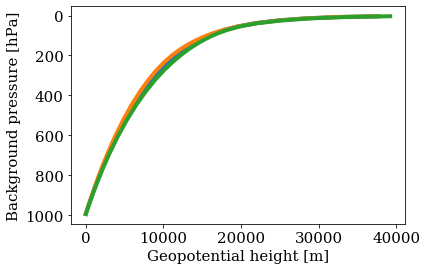

In [49]:
plt.plot(np.mean(z,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(z,25,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(z,75,axis=(0,2,3)),data.lev)
plt.gca().invert_yaxis()
plt.xlabel('Geopotential height [m]')
plt.ylabel('Background pressure [hPa]')

In [50]:
mse = L_V*data.QAP+C_P*data.TAP+G*z # Local MSE 

Text(0, 0.5, 'Background pressure [hPa]')

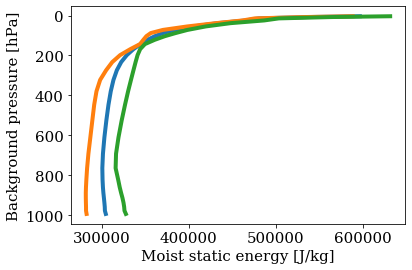

In [52]:
plt.plot(np.mean(mse,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(mse,25,axis=(0,2,3)),data.lev)
plt.plot(np.percentile(mse,75,axis=(0,2,3)),data.lev)
plt.gca().invert_yaxis()
plt.xlabel('Moist static energy [J/kg]')
plt.ylabel('Background pressure [hPa]')

Column MSE assuming that the background pressure is hydrostatic

In [56]:
MSE = sin.trapz(x=1e2*data.lev.values/G,y=mse,axis=1)

In [57]:
MSE.shape

(1488, 64, 128)

Create time coordinate

In [62]:
dt = 1800; # Timestep in seconds
tcoor = dt*np.arange(0,data.time.shape[0])

Plot conditionally-averaged MSE as a function of latitude, longitude, and time

Text(0.5, 0, 'Time [day]')

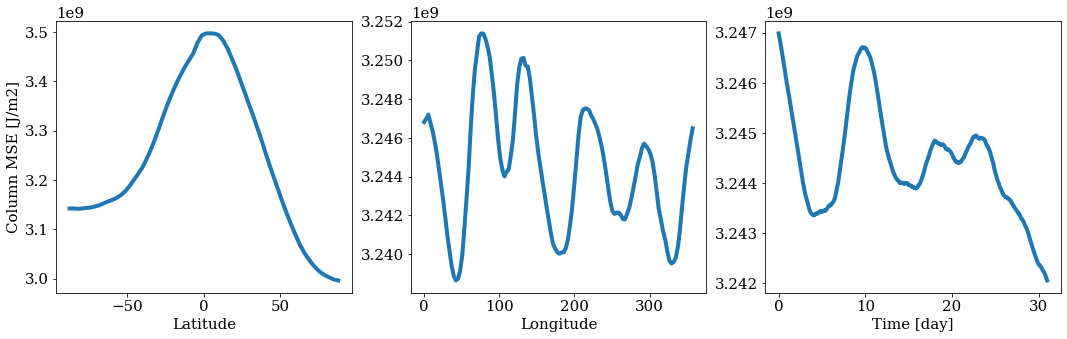

In [68]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,5))

ax[0].plot(data.lat,np.mean(MSE,axis=(0,2)))
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Column MSE [J/m2]')

ax[1].plot(data.lon,np.mean(MSE,axis=(0,1)))
ax[1].set_xlabel('Longitude')

ax[2].plot(tcoor/(24*3600),np.mean(MSE,axis=(1,2)))
ax[2].set_xlabel('Time [day]')

## Estimate time-tendency of MSE

In [70]:
t_range = np.arange(0,np.size(data.time)-2)
dMSE_dt = (MSE[t_range+2,:,:]-MSE[t_range,:,:])/(2*dt)

## Estimate MSE advection as residual of column MSE budget

In [72]:
data.FLNS.mean().values

array(50.23401, dtype=float32)

In [73]:
data.FLNT.mean().values

array(224.87924, dtype=float32)

In [74]:
data.FSNS.mean().values

array(159.7535, dtype=float32)

In [75]:
data.FSNT.mean().values

array(227.18353, dtype=float32)

In [76]:
data.SHFLX.mean().values

array(15.9253845, dtype=float32)

In [77]:
data.LHFLX.mean().values

array(71.66172, dtype=float32)

In [79]:
LW = (data.FLNS-data.FLNT)[t_range+1,:,:]  # Longwave heating [W/m2]
SW = (data.FSNT-data.FSNS)[t_range+1,:,:] # Shortwave heating [W/m2]
SEF = (data.SHFLX+data.LHFLX)[t_range+1,:,:] # Surface enthalpy fluxes [W/m2]

In [80]:
ADV = dMSE_dt-LW-SW-SEF # MSE advection calculated as residual

Text(0.5, 0, 'Time [day]')

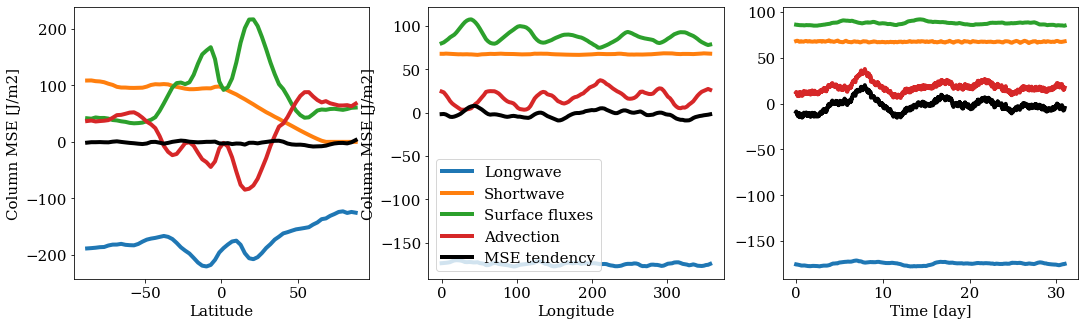

In [87]:
fig,ax = plt.subplots(nrows=1,ncols=3,figsize=(18,5))

ax[0].plot(data.lat,np.mean(LW,axis=(0,2)),label='Longwave')
ax[0].plot(data.lat,np.mean(SW,axis=(0,2)),label='Shortwave')
ax[0].plot(data.lat,np.mean(SEF,axis=(0,2)),label='Surface fluxes')
ax[0].plot(data.lat,np.mean(ADV,axis=(0,2)),label='Advection')
ax[0].plot(data.lat,np.mean(dMSE_dt,axis=(0,2)),label='MSE tendency',color='k')
ax[0].set_xlabel('Latitude')
ax[0].set_ylabel('Column MSE [J/m2]')

ax[1].plot(data.lon,np.mean(LW,axis=(0,1)),label='Longwave')
ax[1].plot(data.lon,np.mean(SW,axis=(0,1)),label='Shortwave')
ax[1].plot(data.lon,np.mean(SEF,axis=(0,1)),label='Surface fluxes')
ax[1].plot(data.lon,np.mean(ADV,axis=(0,1)),label='Advection')
ax[1].plot(data.lon,np.mean(dMSE_dt,axis=(0,1)),label='MSE tendency',color='k')
ax[1].set_xlabel('Longitude')
ax[1].legend()
ax[1].set_ylabel('Column MSE [J/m2]')

ax[2].plot(tcoor[t_range+1]/(24*3600),np.mean(LW,axis=(1,2)),label='Longwave')
ax[2].plot(tcoor[t_range+1]/(24*3600),np.mean(SW,axis=(1,2)),label='Shortwave')
ax[2].plot(tcoor[t_range+1]/(24*3600),np.mean(SEF,axis=(1,2)),label='Surface fluxes')
ax[2].plot(tcoor[t_range+1]/(24*3600),np.mean(ADV,axis=(1,2)),label='Advection')
ax[2].plot(tcoor[t_range+1]/(24*3600),np.mean(dMSE_dt,axis=(1,2)),label='MSE tendency',color='k')
ax[2].set_xlabel('Time [day]')

# Zonal spectra

## Zonal spectrum of MSE

## Zonal spectrum of MSE budget terms

## Zonal spectral MSE budget